In [2]:
import torch
import torchvision
import numpy as np

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import umap

from torch.autograd import Variable

import matplotlib.pyplot as plt
import pylab

In [3]:
# import datasets 
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform= transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5)) ]) # Need to convert it to a tensor to run on GPU, need to normalize it in order to improve convergence. 
trainset= torchvision.datasets.CIFAR10(root= './data', train=True, download= True, transform= transform)
trainloader= torch.utils.data.DataLoader(trainset, batch_size= 32, shuffle= True)

testset= torchvision.datasets.CIFAR10(root= './data', train=False, download= True, transform= transform)
testloader= torch.utils.data.DataLoader(testset, batch_size= 32, shuffle= True)

Files already downloaded and verified
Files already downloaded and verified


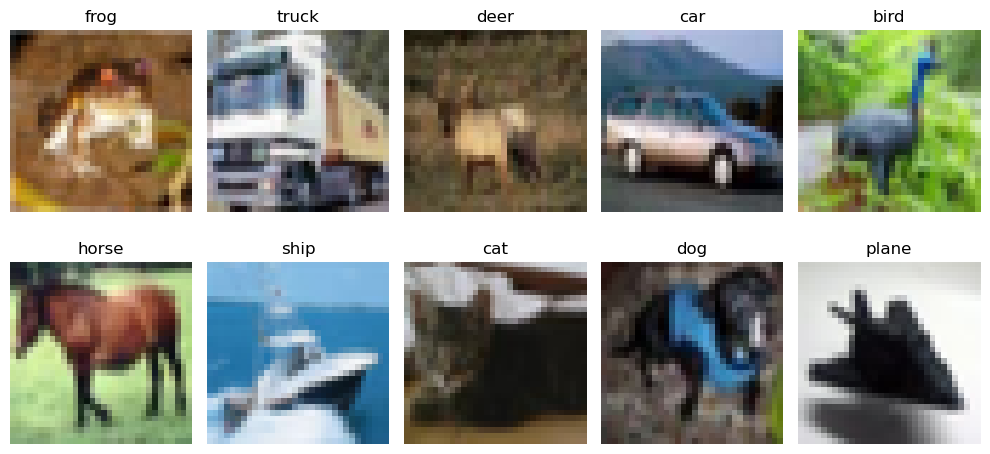

In [5]:
# Display one image from each class in the CIFAR-10 dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# Example classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Initialize a dictionary to store whether we already displayed an image from each class
displayed_classes = {}

for img, label in trainset:
    class_name = classes[label]
    if class_name not in displayed_classes:
        ax = axes[len(displayed_classes) // 5, len(displayed_classes) % 5]
        ax.imshow(np.transpose(img.numpy() * 0.5 + 0.5, (1, 2, 0)))  # Rescale the image for viewing
        ax.set_title(class_name)
        ax.axis('off')
        displayed_classes[class_name] = True

    # Stop when we have displayed one image for each class
    if len(displayed_classes) == len(classes):
        break

plt.tight_layout()
plt.show()

In [6]:
# Define a Convolutional VAE architecture for CIFAR-10 (latent space size 10)
# Image_size= size of the image
# Feature_volume= images multiplied by the number of feature maps. 
# z_size= the size of the latent space- in github, the default was found to be 128 in size. 
# kernel_no= number of feature maps
# channel_no= number of channels
class VAE(nn.Module):
    def __init__(self, image_size, z_size, kernel_no, channel_no):
        super(VAE, self).__init__()
        
        self.image_size= image_size
        self.z_size= z_size
        self.kernel_no= kernel_no
        self.channel_no= channel_no
        
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, self.kernel_no // 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.kernel_no // 4),
            nn.Sigmoid(),
            nn.Conv2d(self.kernel_no // 4, self.kernel_no // 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.kernel_no // 2),
            nn.Sigmoid(),
            nn.Conv2d(self.kernel_no // 2, self.kernel_no, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.kernel_no),
            nn.Sigmoid(),
        )
        
        #Ends at ReLU, nothing more. flattening and dense connections are done elsewhere. 
        
        #Need to implement functions-
        #Functions to be implemented- 
        # q-mean- this function takes the input of the encoder and transforms it to the size of the feature volume. 
        # From here the mean and standard deviation of the latent space is determined.
        # z-reparametrize
        # sample- images from the decoder
        
        
        self.feature_size= image_size // 8 ## Represents images after being encoded by the encoder. The images transform into feature maps.
        self.feature_volume= self.kernel_no * (self.feature_size ** 2) ## Represents the volume of features with the kernel number as the depth. 
        
        # q
        self.q_mean = self._linear(self.feature_volume, z_size, relu= False) 
        self.q_logvar = self._linear(self.feature_volume, z_size, relu= False)
        
        # projection
        self.project = self._linear(z_size, self.feature_volume, relu=False)

        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.kernel_no, self.kernel_no // 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.kernel_no // 2),
            nn.Sigmoid(),
            nn.ConvTranspose2d(self.kernel_no // 2, self.kernel_no // 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.kernel_no // 4),
            nn.Sigmoid(),
            nn.ConvTranspose2d(self.kernel_no // 4, self.channel_no, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.channel_no),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x) # dimensions of encoded are [batch size, kernel no, feature size, feature size]
        q_mu, q_log_var= self.q(encoded) # Takes encoded feature volume as input and returns the mean and variance of the posterior distribution (the assumptions/mental model of the data)
        z = self.reparameterize(q_mu, q_log_var)
        z_projected= self.project(z).view(
        -1, self.kernel_no, 
        self.feature_size, 
        self.feature_size
        )
        
        x_reconstructed= self.decoder(z_projected)
        
        return x_reconstructed, q_mu, q_log_var
    
    def _linear(self, in_size, out_size, relu= True):
        return nn.Sequential(
            nn.Linear(in_size, out_size),
            nn.ReLU(),
        ) if relu else nn.Linear(in_size, out_size)
    
    def q(self, encoded):
        unrolled = encoded.view(-1, self.feature_volume)
        return self.q_mean(unrolled), self.q_logvar(unrolled)
    
    def _is_on_cuda(self):
        return next(self.parameters()).is_cuda
    
    def sample(self, size):
        z = Variable(
            torch.randn(size, self.z_size).cuda() if self._is_on_cuda() else
            torch.randn(size, self.z_size)
        )
        z_projected = self.project(z).view(
            -1, self.kernel_no,
            self.feature_size,
            self.feature_size,
        )
        return self.decoder(z_projected).data
    
    def encoded_image(self, stack):
        encoded= self.encoder(stack)
        z_projected = self.project(z).view(
            -1, self.kernel_no,
            self.feature_size,
            self.feature_size,
        )
        return self.decoder(z_projected).data
        
        
        
# Prepare the CIFAR-10 dataset for VAE training
vae = VAE(image_size= 32, z_size= 128, kernel_no= 128, channel_no= 3)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

SyntaxError: expected ':' (2395955330.py, line 106)

In [81]:
print("Is GPU accessible : ", torch.cuda.is_available())
print("Model moved to : ",next(vae.parameters()).device)
vae.to("cuda")
print("Model moved to :", next(vae.parameters()).device)

Is GPU accessible :  True
Model moved to :  cpu
Model moved to : cuda:0


In [82]:
# Define the loss function (reconstruction + KL divergence)
def loss_function(recon_x, x, mu, log_var):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_loss

# Train the VAE
epochs = 10  # Set number of epochs
for epoch in range(epochs):
    for img_batch, _ in trainloader:
        img_batch= img_batch.to(device)
        optimizer.zero_grad()
        recon, mu, log_var = vae(img_batch)
        loss = loss_function(recon, img_batch, mu, log_var)
        loss.backward()
        optimizer.step()

In [99]:
synthetic_data= vae.sample(85)

In [100]:
synthetic_data= synthetic_data.cpu()
synthetic_data= synthetic_data.numpy()
np.size(synthetic_data)

261120

In [101]:
def imgshow(img):
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.axis('off')
    

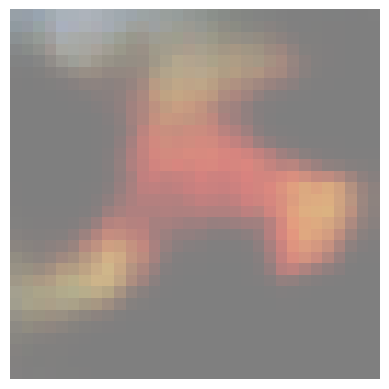

In [141]:
imgshow(synthetic_data[31]*0.5+0.5)

## Image-to-Image Comparison

### Planes

In [126]:
plane_set= []

for img, label in trainset:
    class_name= classes[label]
    if(class_name != 'plane'):
        continue
    else:
        plane_set.append(img.numpy())
    
    if(len(plane_set) == 10):
        break

def imgshow(img):
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.axis('off')

In [128]:
np.shape(plane_set[0])

(3, 32, 32)

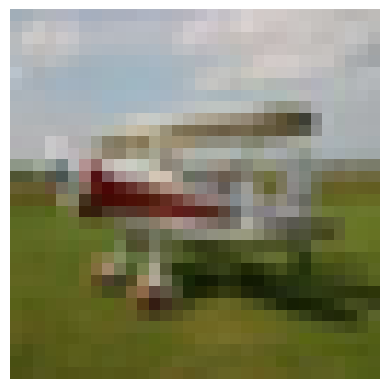

In [145]:
imgshow(plane_set[9] * 0.5 + 0.5)

In [ ]:
# Define an encoder class in the VAE class- in order to sample images from the latent space of the encoder- the posterior distribution Q(z|x)
plane_set= []
for img_batch, label_batch in trainloader:
    for i,_ in enumerate(img_batch):
        class_name= classes[label_batch[i]]
        if(class_name != 'plane'):
            continue
        else:
            plane_set.append(img_batch[i].numpy())
            

## UMAP Visualization

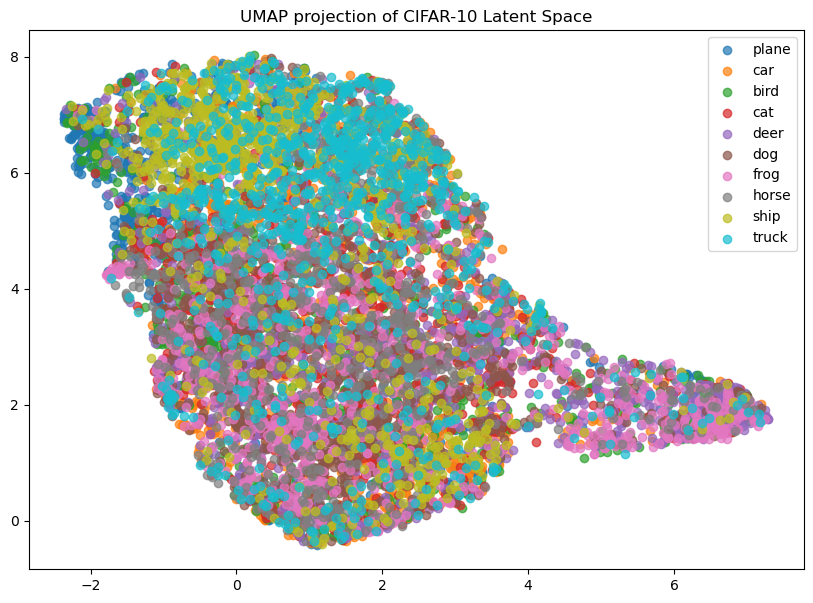

In [9]:
#Problem with UMAP is that each point is a distribution and this is lost via UMAP projection making it difficult to map back to its original high-dimensional space. 
#Simpler approach is to use PCA and combine it into an axis that captures maximum variations. Or even better, look through the original space itself. 
import umap
import matplotlib.pyplot as plt

# Use UMAP to reduce latent space to 2D for visualization
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1)
umap_embedding = umap_model.fit_transform(latent_vectors)

# Plot the 2D UMAP projection, coloring by the true labels
plt.figure(figsize=(10, 7))
for i, class_name in enumerate(classes):
    indices = np.where(test_labels == i)
    plt.scatter(umap_embedding[indices, 0], umap_embedding[indices, 1], label=class_name, alpha=0.7)
plt.legend(loc='best')
plt.title('UMAP projection of CIFAR-10 Latent Space')
plt.show()